In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [2]:
df = pd.read_csv("../DATA/gafa_stock.csv")
df = df[df["unique_id"] == "FB_Close"]
df["ds"] = pd.to_datetime(df["ds"])
df["index"] = df["ds"]
df = df.set_index("index")
df.head()

,unique_id,ds,y
index,,,
2014-01-02,FB_Close,2014-01-02,54.71
2014-01-03,FB_Close,2014-01-03,54.56
2014-01-06,FB_Close,2014-01-06,57.20
2014-01-07,FB_Close,2014-01-07,57.92
2014-01-08,FB_Close,2014-01-08,58.23


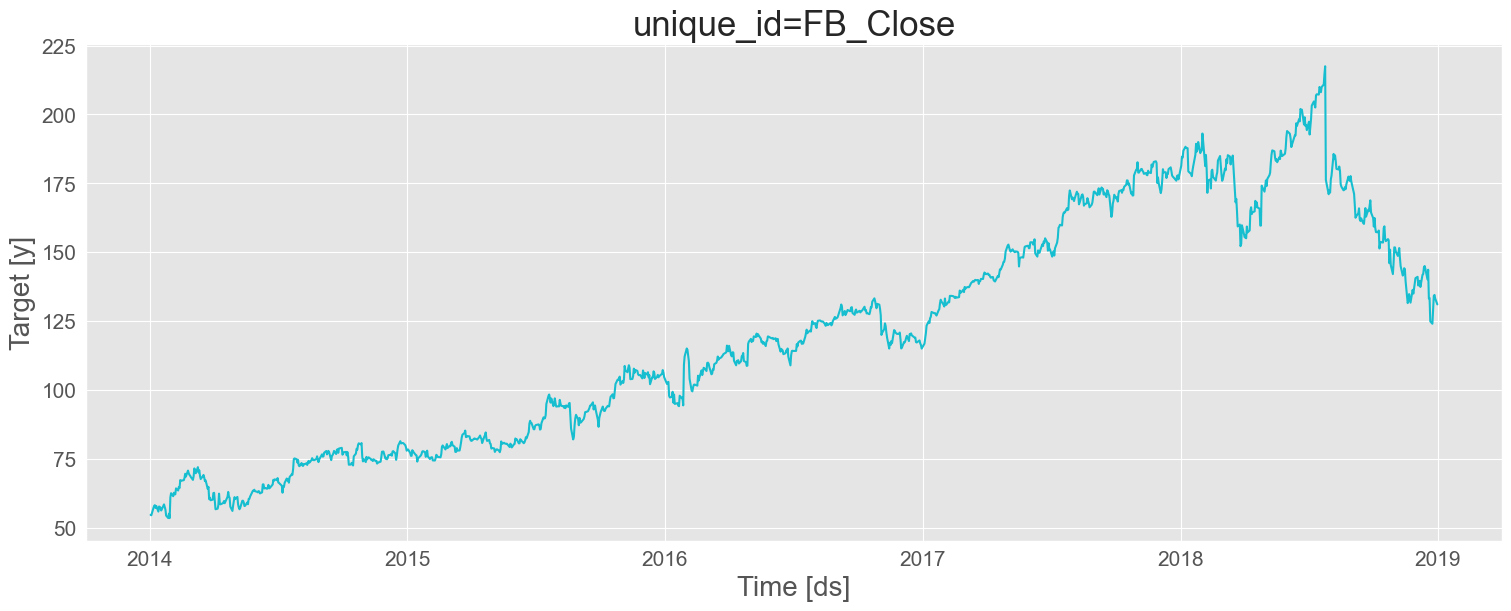

In [3]:
plot_series(df)

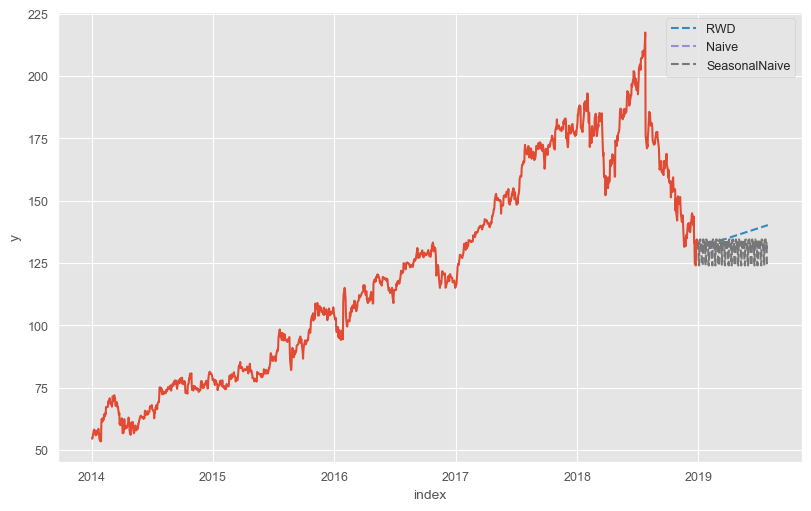

In [27]:
oos = 240
method_list = [RandomWalkWithDrift(), Naive(), SeasonalNaive(season_length=7)]
sns.lineplot(x=df.index, y=df.y)
for method in method_list:
    sf = StatsForecast(models=[method], freq="B")
    prediction = sf.fit_predict(df=df, h=150)
    prediction = prediction.set_index("ds")
    sns.lineplot(
        x=prediction.index,
        y=prediction.iloc[:, 1],
        linestyle="--",
        label=prediction.columns[1],
    )